# Random Forest

In this notebook, I will implement a Random Forest ensemble algorithm, for both classification & regression problems. 

The data I will use in this notebook will be imported from scikit-learn. For testing the classifier, I will use the wine dataset. For the regression ensemble, I will use the boston housing prices dataset. 

In [1]:
## imports ##
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.datasets import load_wine,load_boston
from sklearn.model_selection import StratifiedKFold,cross_validate
from sklearn.metrics import accuracy_score,precision_score,recall_score,mean_absolute_error,mean_squared_error,r2_score,make_scorer
from abc import ABC,abstractmethod
from decisiontrees import DecisionTreeClassifier, DecisionTreeRegressor

In [2]:
## define the random forest classes ##

#base class for the random forest algorithm
class RandomForest(ABC):
    #initializer
    def __init__(self,n_trees=100):
        self.n_trees = n_trees
        self.trees   = []
        
    #private function to make bootstrap samples
    def __make_bootstraps(self,data):
        #initialize output dictionary & unique value count
        dc   = {}
        unip = 0
        #get sample size
        b_size = data.shape[0]
        #get list of row indexes
        idx = [i for i in range(b_size)]
        #loop through the required number of bootstraps
        for b in range(self.n_trees):
            #obtain boostrap samples with replacement
            sidx   = np.random.choice(idx,replace=True,size=b_size)
            b_samp = data[sidx,:]
            #compute number of unique values contained in the bootstrap sample
            unip  += len(set(sidx))
            #obtain out-of-bag samples for the current b
            oidx   = list(set(idx) - set(sidx))
            o_samp = np.array([])
            if oidx:
                o_samp = data[oidx,:]
            #store results
            dc['boot_'+str(b)] = {'boot':b_samp,'test':o_samp}
        #return the bootstrap results
        return(dc)
  
    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees}

    #protected function to obtain the right decision tree
    @abstractmethod
    def _make_tree_model(self):
        pass
    
    #protected function to train the ensemble
    def _train(self,X_train,y_train):
        #package the input data
        training_data = np.concatenate((X_train,y_train.reshape(-1,1)),axis=1)
        #make bootstrap samples
        dcBoot = self.__make_bootstraps(training_data)
        #iterate through each bootstrap sample & fit a model ##
        tree_m = self._make_tree_model()
        dcOob    = {}
        for b in dcBoot:
            #make a clone of the model
            model = clone(tree_m)
            #fit a decision tree model to the current sample
            model.fit(dcBoot[b]['boot'][:,:-1],dcBoot[b]['boot'][:,-1].reshape(-1, 1))
            #append the fitted model
            self.trees.append(model)
            #store the out-of-bag test set for the current bootstrap
            if dcBoot[b]['test'].size:
                dcOob[b] = dcBoot[b]['test']
            else:
                dcOob[b] = np.array([])
        #return the oob data set
        return(dcOob)
       
    #protected function to predict from the ensemble
    def _predict(self,X):
        #check we've fit the ensemble
        if not self.trees:
            print('You must train the ensemble before making predictions!')
            return(None)
        #loop through each fitted model
        predictions = []
        for m in self.trees:
            #make predictions on the input X
            yp = m.predict(X)
            #append predictions to storage list
            predictions.append(yp.reshape(-1,1))
        #compute the ensemble prediction
        ypred = np.mean(np.concatenate(predictions,axis=1),axis=1)
        #return the prediction
        return(ypred)

In [3]:
#class for random forest classifier
class RandomForestClassifier(RandomForest):
    #initializer
    def __init__(self,n_trees=100,max_depth=None,min_samples_split=2,loss='gini',balance_class_weights=False):
        super().__init__(n_trees)
        self.max_depth             = max_depth
        self.min_samples_split     = min_samples_split
        self.loss                  = loss
        self.balance_class_weights = balance_class_weights
        
    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeClassifier(max_depth             = self.max_depth,
                                      min_samples_split     = self.min_samples_split,
                                      loss                  = self.loss,
                                      balance_class_weights = self.balance_class_weights))
    
    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'loss':self.loss,
                'balance_class_weights':self.balance_class_weights}
    
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            accs = np.array([])
            pres = np.array([])
            recs = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp  = m.predict(dcOob[b][:,:-1])
                    acc = accuracy_score(dcOob[b][:,-1],yp)
                    pre = precision_score(dcOob[b][:,-1],yp,average='weighted')   
                    rec = recall_score(dcOob[b][:,-1],yp,average='weighted')
                    #store the error metrics
                    accs = np.concatenate((accs,acc.flatten()))
                    pres = np.concatenate((pres,pre.flatten()))
                    recs = np.concatenate((recs,rec.flatten()))
            #print standard errors
            print("Standard error in accuracy: %.2f" % np.std(accs))
            print("Standard error in precision: %.2f" % np.std(pres))
            print("Standard error in recall: %.2f" % np.std(recs))
            
    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #convert the results into integer values & return
        return(np.round(ypred).astype(int))

In [4]:
#class for random forest regressor
class RandomForestRegressor(RandomForest):
    #initializer
    def __init__(self,n_trees=100,max_depth=None,min_samples_split=2,loss='mse'):
        super().__init__(n_trees)
        self.max_depth             = max_depth
        self.min_samples_split     = min_samples_split
        self.loss                  = loss
        
    #protected function to obtain the right decision tree
    def _make_tree_model(self):
        return(DecisionTreeRegressor(self.max_depth,self.min_samples_split,self.loss))
    
    #public function to return model parameters
    def get_params(self, deep = False):
        return {'n_trees':self.n_trees,
                'max_depth':self.max_depth,
                'min_samples_split':self.min_samples_split,
                'loss':self.loss}
    
    #train the ensemble
    def fit(self,X_train,y_train,print_metrics=False):
        #call the protected training method
        dcOob = self._train(X_train,y_train)
        #if selected, compute the standard errors and print them
        if print_metrics:
            #initialise metric arrays
            maes = np.array([])
            mses = np.array([])
            r2ss = np.array([])
            #loop through each bootstrap sample
            for b,m in zip(dcOob,self.trees):
                #compute the predictions on the out-of-bag test set & compute metrics
                if dcOob[b].size:
                    yp  = m.predict(dcOob[b][:,:-1])
                    mae = mean_absolute_error(dcOob[b][:,-1],yp)
                    mse = mean_squared_error(dcOob[b][:,-1],yp)   
                    r2s = r2_score(dcOob[b][:,-1],yp)
                    #store the error metrics
                    maes = np.concatenate((maes,mae.flatten()))
                    mses = np.concatenate((mses,mse.flatten()))
                    r2ss = np.concatenate((r2ss,r2s.flatten()))
            #print standard errors
            print("Standard error in mean absolute error: %.2f" % np.std(maes))
            print("Standard error in mean squred error: %.2f" % np.std(mses))
            print("Standard error in r2 score: %.2f" % np.std(r2ss))
            
    #predict from the ensemble
    def predict(self,X):
        #call the protected prediction method
        ypred = self._predict(X)
        #return the results
        return(ypred)  

## Wine Dataset - Classification

First let's take a look at the available wine dataset. We'll import these data into the notebook, and then do some exploratory analysis.

In [5]:
#load the wine dataset
dfX,sY = load_wine(return_X_y=True, as_frame=True)

In [6]:
#check the dimensions of these data
print('Dimensions of X: ',dfX.shape)
print('Dimensions of y: ',sY.shape)

Dimensions of X:  (178, 13)
Dimensions of y:  (178,)


In [7]:
#what unique classes exist in the label variable?
print('Classes in the label: ',sY.unique())

Classes in the label:  [0 1 2]


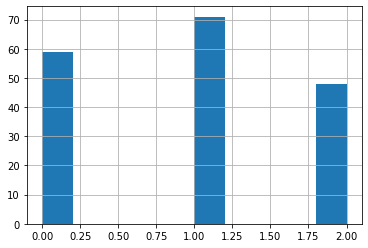

In [8]:
#what is the frequency of the classes in the dataset?
sY.hist()
plt.show()

In [9]:
#view the first 5 rows of input features
dfX.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


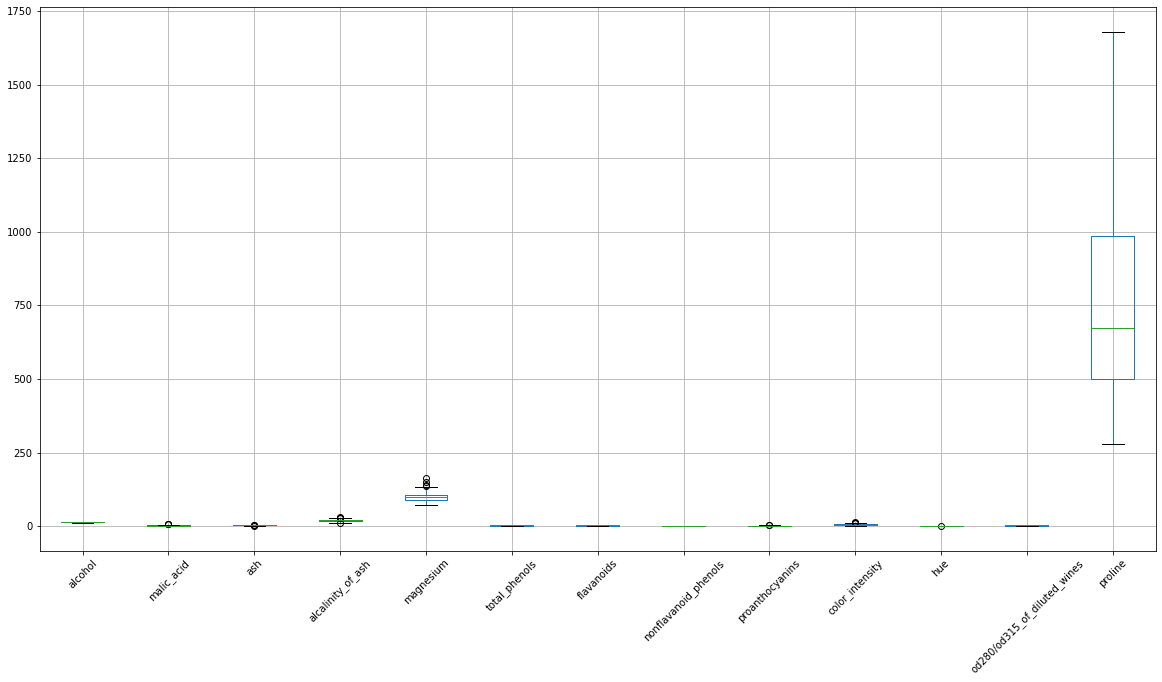

In [10]:
#make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10),rot=45)
plt.show()

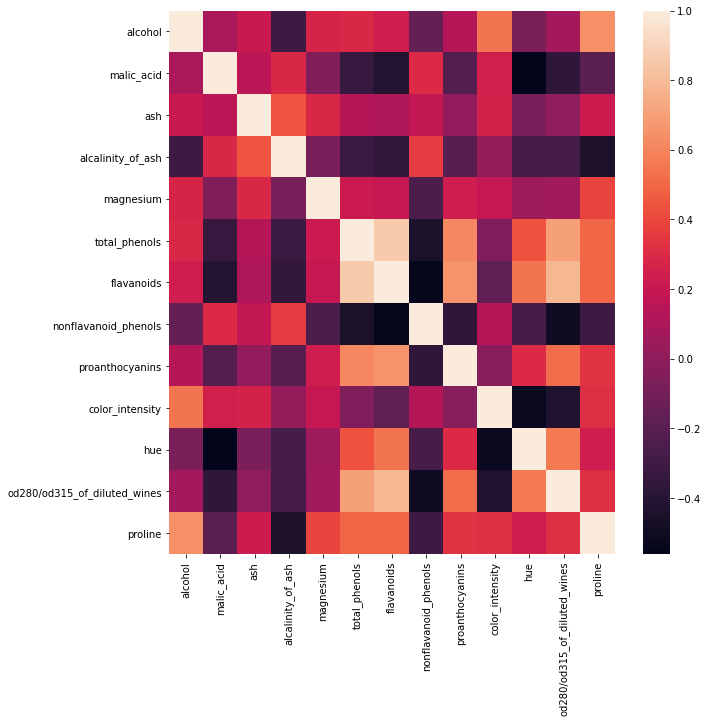

In [11]:
## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10)) 
dfCorr  = dfX.corr() 
sn.heatmap(dfCorr) 
plt.show()

We have a total of 178 samples, with 13 input features. Each sample can be given one of 3 possible class labels, corresponding to 3 different wine qualities. These classes are unbalanced in the dataset. The spreads in these data vary from feature-to-feature, however there appears to be virtually no outliers present. Some input features appear to be highly correlated.

Let's now identify features that show a high degree of colinearity (i.e. greater than 0.8):

In [12]:
#convert all correlations to positive values
dfCorr = dfCorr.abs()

In [13]:
#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)

highly correlated input features:  total_phenols  &  ['flavanoids']
highly correlated input features:  flavanoids  &  ['total_phenols']


Only two features show a high degree of colinearity, total_phenols & flavanoids. In situations where we have a large number of features (1000's or more), we could remove these to reduce the dimensionality of the data. However, with our present dataset we can safely proceed without dropping any features.

We can now create an instance of our custom random forest classifier, and train it to view the standard error estimates:

In [14]:
#create a random forest with balance class weights enabled
rfc = RandomForestClassifier(balance_class_weights=True)

In [15]:
## train the ensemble & view estimates for prediction error ##
rfc.fit(dfX.values,sY.values,print_metrics=True)

Standard error in accuracy: 0.06
Standard error in precision: 0.05
Standard error in recall: 0.06


In [16]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.97
Mean Precision: 0.97
Mean Recall: 0.97


These results look good. Note that here I'm just using the default hyperparameters for the random forest classifier. Let's now compare these results with the models available through scikit-learn. We will look at a Random Forest Classifer, a Bagging Classifier, and a Decision Tree Classifier:

In [26]:
## import the scikit-learn models ##
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

In [27]:
#create a random forest with balanced class weights
rfc = RandomForestClassifier(class_weight='balanced')

In [28]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(rfc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.98
Mean Precision: 0.98
Mean Recall: 0.98


In [29]:
#create a bagging classifer with balanced class weights
btc = BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced'),n_estimators=100)

In [30]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(btc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.94
Mean Precision: 0.95
Mean Recall: 0.94


In [31]:
#create a decision tree classifer with balanced class weights
dtc = DecisionTreeClassifier(class_weight='balanced')

In [32]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'accuracy': make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score, average='weighted'),
                   'recall': make_scorer(recall_score, average='weighted')}
dcScores        = cross_validate(dtc,dfX.values,sY.values,cv=StratifiedKFold(10),scoring=scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(dcScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(dcScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(dcScores['test_recall']))

Mean Accuracy: 0.89
Mean Precision: 0.92
Mean Recall: 0.89


Model | Accuracy | Precision | Recall
--- | --- | --- | ---
Custom Random Forest | 0.97 | 0.97 | 0.97
Scikit-Learn Random Forest | 0.98 | 0.98 | 0.98
Scikit-Learn Bagging Classifier | 0.94 | 0.95 | 0.94
Scikit-Learn Decision Tree Classifier | 0.89 | 0.92 | 0.89

The results show that our custom built random forest classifier performs similarily to the model available through scikit-learn. In addition, we can see that the random forest algorithm performs better than the bagging classifier, and the decision tree algorithm.

## Boston House Prices Dataset - Regression

We can now look at a regression problem, the boston house prices dataset. Let's import these data into the notebook, and do some exploratory analysis.

In [17]:
#load the boston dataset
data = load_boston()
#obtain input data
X = data.data
#obtain labels
Y = data.target
#obtain input labels
names = data.feature_names
#convert input features to dataframe
dfX = pd.DataFrame(X,columns=names)

In [18]:
#check the dimensions of these data
print('Dimensions of X: ',dfX.shape)
print('Dimensions of y: ',Y.shape)

Dimensions of X:  (506, 13)
Dimensions of y:  (506,)


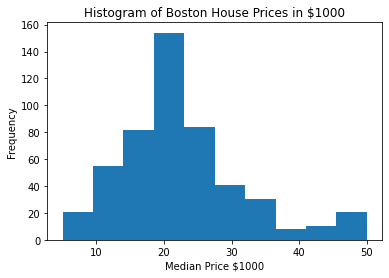

In [19]:
#produce a histogram of the target labels
plt.hist(Y)
plt.xlabel('Median Price $1000')
plt.ylabel('Frequency')
plt.title('Histogram of Boston House Prices in $1000')
plt.show()

In [20]:
#view the first 5 rows of input features
dfX.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


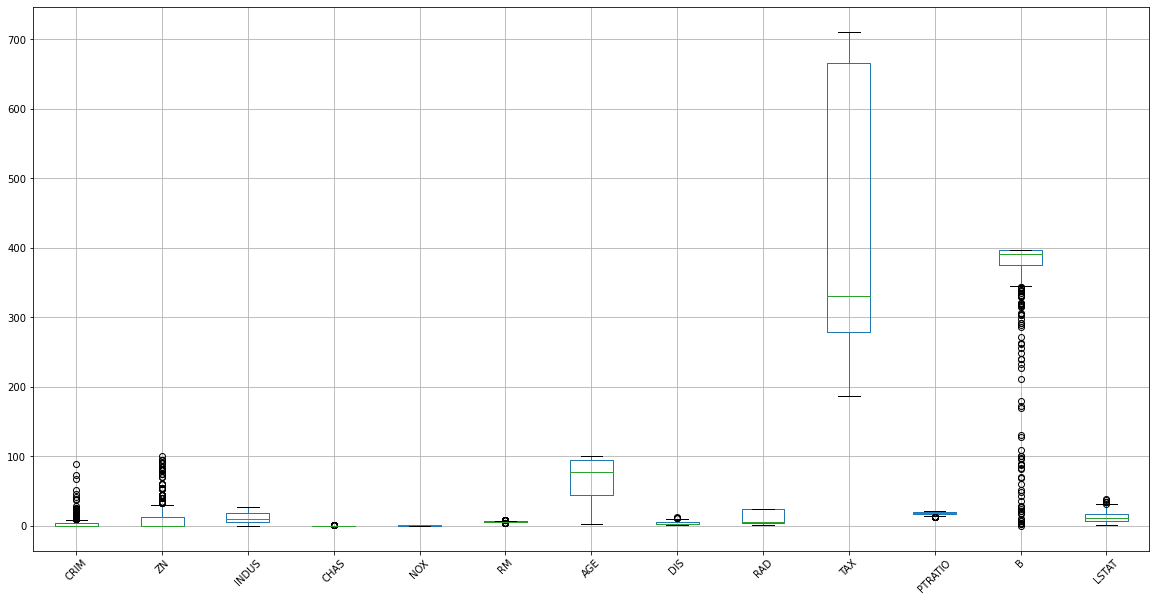

In [21]:
#make a boxplot to view the distribution in these data
dfX.boxplot(figsize=(20,10),rot=45)
plt.show()

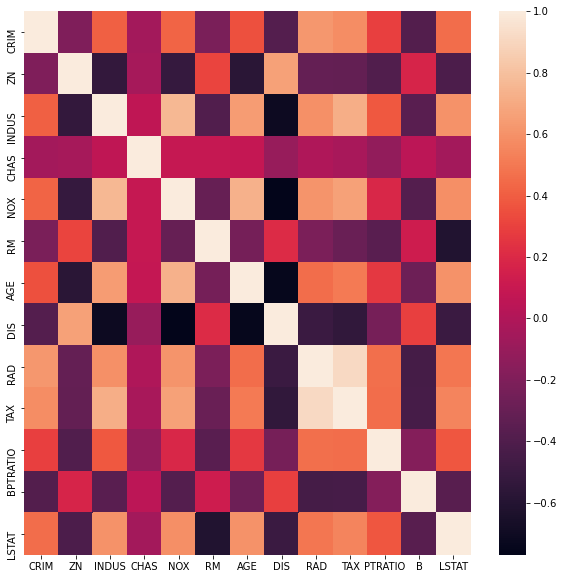

In [22]:
## plot the pearson correlation for our input features ##
fig, ax = plt.subplots(figsize = (10, 10)) 
dfCorr  = dfX.corr() 
sn.heatmap(dfCorr) 
plt.show()

We have a total of 506 samples, with 13 input features. The target $y$ represents the median house price in $\$$1000's USD. Note that these data were published in 1978, and therefore refect dollars from that time period. The distribution peaks around $\$$20,000, however there is a secondary minor peak around $\$$50,000. The spreads in these data vary from feature-to-feature, with many outliers present in CRIM, ZN, and B. Some input features appear to be highly correlated.

Let's now identify features that show a high degree of colinearity (i.e. greater than 0.8):

In [23]:
#convert all correlations to positive values
dfCorr = dfCorr.abs()

In [24]:
#loop through rows
for index, sRow in dfCorr.iterrows():
    #get the valid entries
    sCorrs = sRow[sRow.index != index]
    sCorrs = sCorrs[sCorrs > 0.8]
    #print out results
    if not sCorrs.empty:
        print('highly correlated input features: ',index,' & ',sCorrs.index.values)

highly correlated input features:  RAD  &  ['TAX']
highly correlated input features:  TAX  &  ['RAD']


Like the case with the wine dataset, only two features show a high degree of colinearity, RAD & TAX. In situations where we have a large number of features (1000's or more), we could remove these to reduce the dimensionality of the data. However, with our present dataset we can safely proceed without dropping any features.

We can now create an instance of our custom random forest regressor, and train it to view the standard error estimates:

In [25]:
#create a random forest with default values
rfr = RandomForestRegressor()

In [26]:
## train the ensemble & view estimates for prediction error ##
rfr.fit(dfX.values,Y,print_metrics=True)

Standard error in mean absolute error: 0.37
Standard error in mean squred error: 9.14
Standard error in r2 score: 0.11


In [27]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}
dcScores        = cross_validate(rfr,dfX.values,Y,cv=10,scoring=scoring_metrics)
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))

Mean MAE: 3.05
Mean MSE: 21.47
Mean R2: 0.55


These results look reasonable. Note that no hyperparameters tuning was done, like with the random forest classifier. It is also important to notice the negative $R^2$ score: this implies the model is introducing more variation than is present in the data. However, the $R^2$ metric is supposed to be used strictly for linear models, and as such this value may not be representative of the true performance of the random forest model. 

Let's now compare these results with the models available through scikit-learn. We will look at a Random Forest Regressor, a Bagging Regressor, and a Decision Tree Regressor:

In [28]:
## import the scikit-learn models ##
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor 
from sklearn.tree import DecisionTreeRegressor

In [29]:
#create a random forest with default values
rfr = RandomForestRegressor(max_features='sqrt')

In [30]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}
dcScores        = cross_validate(rfr,dfX.values,Y,cv=10,scoring=scoring_metrics)
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))

Mean MAE: 3.01
Mean MSE: 20.10
Mean R2: 0.55


In [31]:
#create a bagging regressor 
btr = BaggingRegressor(base_estimator=DecisionTreeRegressor(),n_estimators=100)

In [32]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}
dcScores        = cross_validate(btr,dfX.values,Y,cv=10,scoring=scoring_metrics)
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))

Mean MAE: 3.00
Mean MSE: 21.77
Mean R2: 0.51


In [33]:
#create a decision tree regressor 
dtr = DecisionTreeRegressor()

In [34]:
## use k fold cross validation to measure performance ##
scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}
dcScores        = cross_validate(dtr,dfX.values,Y,cv=10,scoring=scoring_metrics)
print('Mean MAE: %.2f' % np.mean(dcScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(dcScores['test_mse']))
print('Mean R2: %.2f' % np.mean(dcScores['test_r2']))

Mean MAE: 3.98
Mean MSE: 38.95
Mean R2: -0.07


Model | MAE | MSE | R2
--- | --- | --- | ---
Custom Random Forest | 3.05 | 21.47 | 0.55
Scikit-Learn Random Forest | 3.01 | 20.10 | 0.55
Scikit-Learn Bagging Regressor | 3.00 | 21.77 | 0.51
Scikit-Learn Decision Tree Regressor | 3.98 | 38.95 | -0.07

The results show that our custom built random forest regressor performs similarily to the model available through scikit-learn in terms of the MAE and $R^2$ scores. The MSE result is a bit better with the scikit-learn model, indicating that this model is better at handling outliers. In addition, we can see that the random forest algorithm performs better than the bagging regressor (in terms of MSE & $R^2$), and the decision tree algorithm.